# Exercise 6

In [ ]:
# Basic
import time
import random
import pickle
from functools import reduce

# Data
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ML
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# DL
from tensorflow.keras.datasets import mnist

## 1 Data

### 1.1 Loading

In [2]:
(X_train, y_train),(X_test, y_test) = mnist.load_data()

# Flatten pixel images
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

# Normalize pixel values
X_train = X_train / 255
X_test = X_test / 255

(X_train_flat.shape, y_train.shape), (X_test_flat.shape, y_test.shape)

(((60000, 784), (60000,)), ((10000, 784), (10000,)))

### 1.2 Visualization

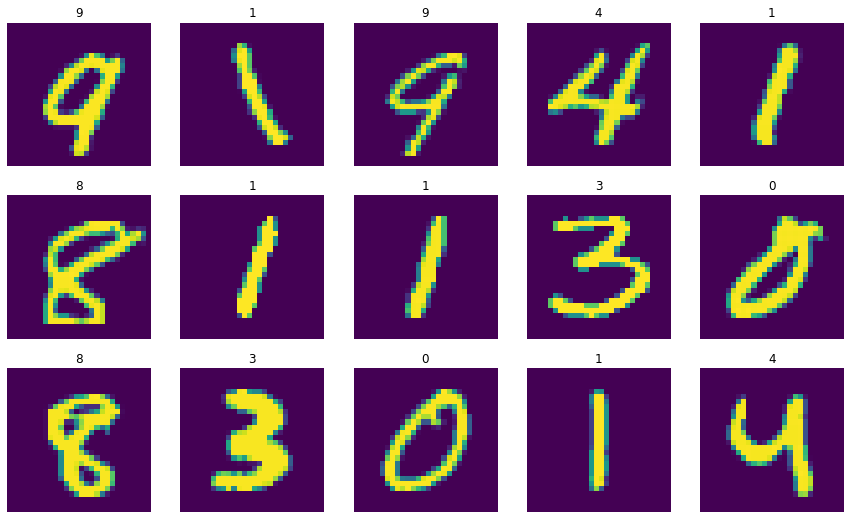

In [3]:
# Plot dimensions
ROWS, COLS = 3, 5
SCALE = 3

# Sampled images
pairs = list(zip(X_train, y_train))
samples = random.sample(pairs, ROWS * COLS)

# Plotting
fig, ax = plt.subplots(ROWS, COLS, figsize=(COLS * SCALE, ROWS * SCALE))
for i, (img, digit) in enumerate(samples):
    row, col = i // COLS, i % COLS
    ax[row, col].imshow(img)
    ax[row, col].set_title(digit)
    ax[row, col].axis('off')

## 2 Model

### 2.1 Weight Initialization

In [5]:
def xavier_normal_init(layer_sizes):
    return [
        np.random.normal(loc=0, scale=np.sqrt(2 / (size_from + size_to)), size=(size_from, size_to))
        for size_from, size_to in zip(layer_sizes[:-1], layer_sizes[1:])
    ]

def xavier_uniform_init(layer_sizes):
    return [
        np.random.uniform(low=-np.sqrt(6 / (size_from + size_to)), high=np.sqrt(6 / (size_from + size_to)), size=(size_from, size_to))
        for size_from, size_to in zip(layer_sizes[:-1], layer_sizes[1:])
    ]
    
def he_normal_init(layer_sizes):
    return [
        np.random.normal(loc=0, scale=np.sqrt(2 / size_from), size=(size_from, size_to))
        for size_from, size_to in zip(layer_sizes[:-1], layer_sizes[1:])
    ]

### 2.2 Activations

In [6]:
class Activation:
    def func(self, x):
        assert False
        
    def grad(self, x):
        assert False
        
class ReLU(Activation):
    def func(self, x):
        return np.maximum(x, 0)

    def grad(self, x):
        return np.where(x > 0, 1, 0)
    
class ReLU6(Activation):
    def func(self, x):
        return np.minimum(np.maximum(x, 0), 6)

    def grad(self, x):
        return np.where(np.bitwise_and(x > 0, x < 6) , 1, 0)

class Sigmoid(Activation):
    def func(self, x):
        return 1 / (1 + np.exp(-x))

    def grad(self, x):
        sig = self.func(x)
        return sig * (1 - sig)
    
class Tanh(Activation):
    def func(self, x):
        exp = np.exp(x)
        return (exp + (1 / exp)) / (exp - (1 / exp))
    
    def grad(self, x):
        return 1 - self.func(x) ** 2
    
def softmax(x):
    exp = np.exp(x)
    return exp / np.sum(exp, axis=-1, keepdims=True)

### 2.3 Loss Function

In [7]:
def cross_entropy_loss(y_true, probabilities):
    return -np.log(probabilities[np.arange(y_true.size), y_true]).sum() / y_true.size

### 2.4 Optimizers

In [8]:
class SGD:
    def __init__(self, weights, beta=0.9):
        self.weights = weights
        self.beta = beta
        self.vt = [np.zeros_like(w) for w in self.weights]
    
    def step(self, gradients, lr):
        for layer, grad in enumerate(gradients):
            
            # Update moment vector
            self.vt[layer] = self.beta * self.vt[layer] + (1 - self.beta) * grad
            
            # Update weights
            self.weights[layer] -= lr * self.vt[layer]
            
        return self.weights

class Adam:
    def __init__(self, weights, beta1=0.9, beta2=0.999):
        self.weights = weights
        self.t = 0
        
        
    def step(self, gradients, lr):
        self.t += 1
        for layer, grad in enumerate(gradients):
            
            # Update moment vectors
            self.mt[layer] = (self.beta1 * self.mt[layer] + (1 - self.beta1) * grad) / (1 - self.beta1 ** self.t)
            self.vt[layer] = (self.beta2 * self.vt[layer] + (1 - self.beta2) * (grad ** 2)) / (1 - self.beta2 ** self.t)
        
            # Update weights    
            self.weights[layer] -= lr * self.mt[layer] / (np.sqrt(self.vt[layer]) + 1e-8)
        
        return self.weights
            

### 2.5 Neural Network

In [10]:
class NeuralNetwork:
    def __init__(self, input_size, hidden_sizes, output_size, weight_init_fn, activation_type, lr, max_iter, validation_size=0.2, shuffle=True):
        self.max_iter = max_iter
        self.validation_size = validation_size
        self.shuffle = shuffle
        self.lr = lr
        
        self.layer_sizes = [input_size, *hidden_sizes, output_size]
        self.weights = weight_init_fn(self.layer_sizes)
        self.gradients = [np.zeros_like(w) for w in self.weights]
        self.mt = [np.zeros_like(w) for w in self.weights]
        self.vt = [np.zeros_like(w) for w in self.weights]
        
        self.activation = activation_type()
        self.lr = lr
        
        self.train_losses = []
        self.val_losses = []

    def forward(self, X):
        
        # Inputs for each layer (hidden & output)
        self.layer_inputs = [np.zeros((X.shape[0], size)) for size in self.layer_sizes[:-1]]
        self.activation_inputs = [np.zeros((X.shape[0], size)) for size in self.layer_sizes[1:]]
        
        # First layer inputs
        self.layer_inputs[0] = X
        
        # Calculate intermediate values
        for layer, weight in enumerate(self.weights[:-1]):
            
            # Linear layer
            self.activation_inputs[layer] = self.layer_inputs[layer] @ weight
            
            # Activation
            self.layer_inputs[layer + 1] = self.activation.func(self.activation_inputs[layer])
            
        # Last linear layer
        self.activation_inputs[-1] = self.layer_inputs[-1] @ self.weights[-1]
        
        # Logits
        self.output = softmax(self.activation_inputs[-1])
    
    def backward(self, y):
        
        # Gradient of loss w.r.t to softmax input
        one_hot_labels = np.zeros_like(self.output)
        one_hot_labels[np.arange(y.size), y] = 1
        delta = self.output - one_hot_labels
        
        # Iterate over layers
        for layer in range(len(self.gradients) - 1, 0, -1):
            
            # Gradient of loss w.r.t layer weights
            self.gradients[layer] = self.layer_inputs[layer].T @ delta
            
            # Gradient of loss w.r.t to previous layer's input
            delta = self.activation.grad(self.activation_inputs[layer - 1]) * (delta @ self.weights[layer].T)

        # Last gradient of loss w.r.t first layer's weights
        self.gradients[0] = self.layer_inputs[0].T @ delta

    def step(self):
        self.beta1 = 0.9
        self.beta2 = 0.99
        
        for layer, grad in enumerate(self.gradients):
            
            # Update moment vectors
            # self.mt[layer] = (self.beta1 * self.mt[layer] + (1 - self.beta1) * grad) / (1 - self.beta1 ** self.iter)
            # self.vt[layer] = (self.beta2 * self.vt[layer] + (1 - self.beta2) * (grad ** 2)) / (1 - self.beta2 ** self.iter)
        
            # # Update weights    
            # self.weights[layer] -= self.lr * self.mt[layer] / (np.sqrt(self.vt[layer]) + 1e-8)
            self.weights[layer] -= self.lr * grad
        

    def single_iter(self, X, y, train=True):
        batch_size = 100
        num_batches = y.size / batch_size
        iter_loss = 0
        
        for i in range(0, y.size, batch_size):
            X_batch, y_batch = X[i:i+batch_size], y[i:i+batch_size]
        
            if not train:
                self.output = self.predict_proba(X_batch)
                
            else:
                self.forward(X_batch)
                self.backward(y_batch)
                self.step()
                
            iter_loss += cross_entropy_loss(y_batch, self.output)
            
        return iter_loss / num_batches
        
    def print_status(self):
        now = time.time()
        hours = int(now - self.start_time) // 3600
        minutes = int(now - self.start_time) // 60 % 60
        seconds = int(now - self.start_time) % 60
        percent = int(100 * self.iter / self.max_iter)
        
        status = f'Train Loss ({self.train_losses[-1]:.3f}), Validation Loss ({self.val_losses[-1]:.3f}): {percent}% {self.iter}/{self.max_iter} [{hours:02d}:{minutes:02d}:{seconds:02d}]'
        print(status, end='\r' if self.iter < self.max_iter else '\n')
        
    def fit(self, X, y):
        self.start_time = time.time()
        self.train_rows, self.val_rows = train_test_split(np.arange(X.shape[0]), test_size=self.validation_size, shuffle=self.shuffle, random_state=42)
        print(self)
        
        # Iterate over data
        for self.iter in range(1, self.max_iter + 1):
            self.train_losses.append(self.single_iter(X[self.train_rows, :], y[self.train_rows]))
            self.val_losses.append(self.single_iter(X[self.val_rows, :], y[self.val_rows], train=False))
            self.print_status()
        
        return self

    def predict_proba(self, X):
        return softmax(reduce(lambda x, w: self.activation.func(x @ w), [X, *self.weights[:-1]]) @ self.weights[-1])

    def predict(self, X):
        return np.argmax(self.predict_proba(X), axis=1)    

    def score(self, X, y):
        return (self.predict(X) == y).sum() / len(y)
    
    def __repr__(self):
        return f'NN_[{"-".join(map(str, self.layer_sizes))}]_{type(self.activation).__name__}'

## 3 Experiments

In [34]:
def plot_learning_curves(ax, nn):
    num_iters = len(nn.train_losses)
    iters = np.arange(1, num_iters + 1)

    # Plot Train & Validation Losses
    ax.plot(iters, nn.train_losses, label='Training Loss')
    ax.plot(iters, nn.val_losses, label='Validation Loss')
    ax.set_title(nn)
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.legend(loc='best')

def plot_confusion_matrix(ax, clf, X, y, tag):
    y_pred = clf.predict(X)
    cm = confusion_matrix(y_true=y, y_pred=y_pred)
    
    sns.heatmap(cm, annot=cm, ax=ax)
    ax.set_ylabel("Ground Truth")
    ax.set_xlabel("Predictions")
    ax.set_title(f'{clf}, {tag} score: {clf.score(X, y):.3f}')

def plot_experiment_summary(nns):
    
    # Plot learning curves
    fig, ax = plt.subplots(1, len(nns), figsize=(10 * len(nns), 10), sharey=True)
    for i, nn in enumerate(nns):
        plot_learning_curves(ax[i], nn)
        
    # Plot confusion matrices
    fig, ax = plt.subplots(2, len(nns), figsize=(10 * len(nns), 20))
    for i, nn in enumerate(nns):
        plot_confusion_matrix(ax[0, i], nn, X_train_flat[nn.train_rows, :], y_train[nn.train_rows], "Train")
        plot_confusion_matrix(ax[1, i], nn, X_train_flat[nn.val_rows, :], y_train[nn.val_rows], "Validation")
        
def run_experiment(experiment, data_size):
    nns = []
    for ex_args in experiment:
        nn = NeuralNetwork(input_size=X_train_flat.shape[1], 
                           output_size=10,
                           **ex_args)
        
        nns.append(nn.fit(X_train_flat[:data_size], y_train[:data_size]))
    
    plot_experiment_summary(nns)

### 3.1 Network Width

NN_[784-1024-10]_Sigmoid
Train Loss (0.096), Validation Loss (0.128): 100% 10/10 [00:01:19]
NN_[784-512-10]_Sigmoid
Train Loss (0.135), Validation Loss (0.151): 100% 10/10 [00:00:44]
NN_[784-256-10]_Sigmoid
Train Loss (0.178), Validation Loss (0.188): 100% 10/10 [00:00:24]
NN_[784-128-10]_Sigmoid
Train Loss (0.223), Validation Loss (0.229): 100% 10/10 [00:00:12]


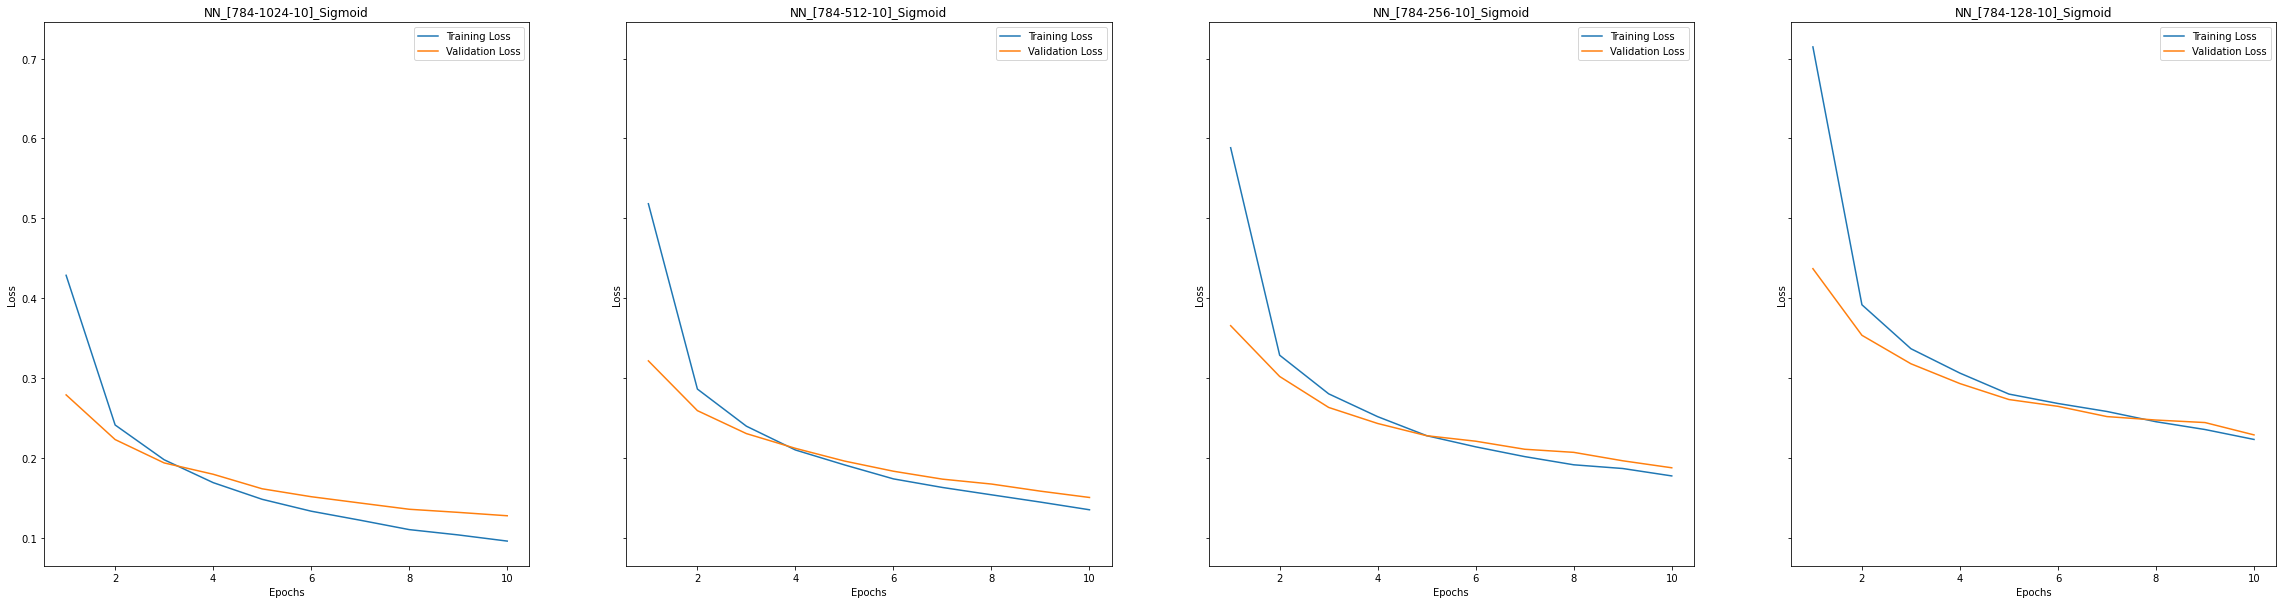

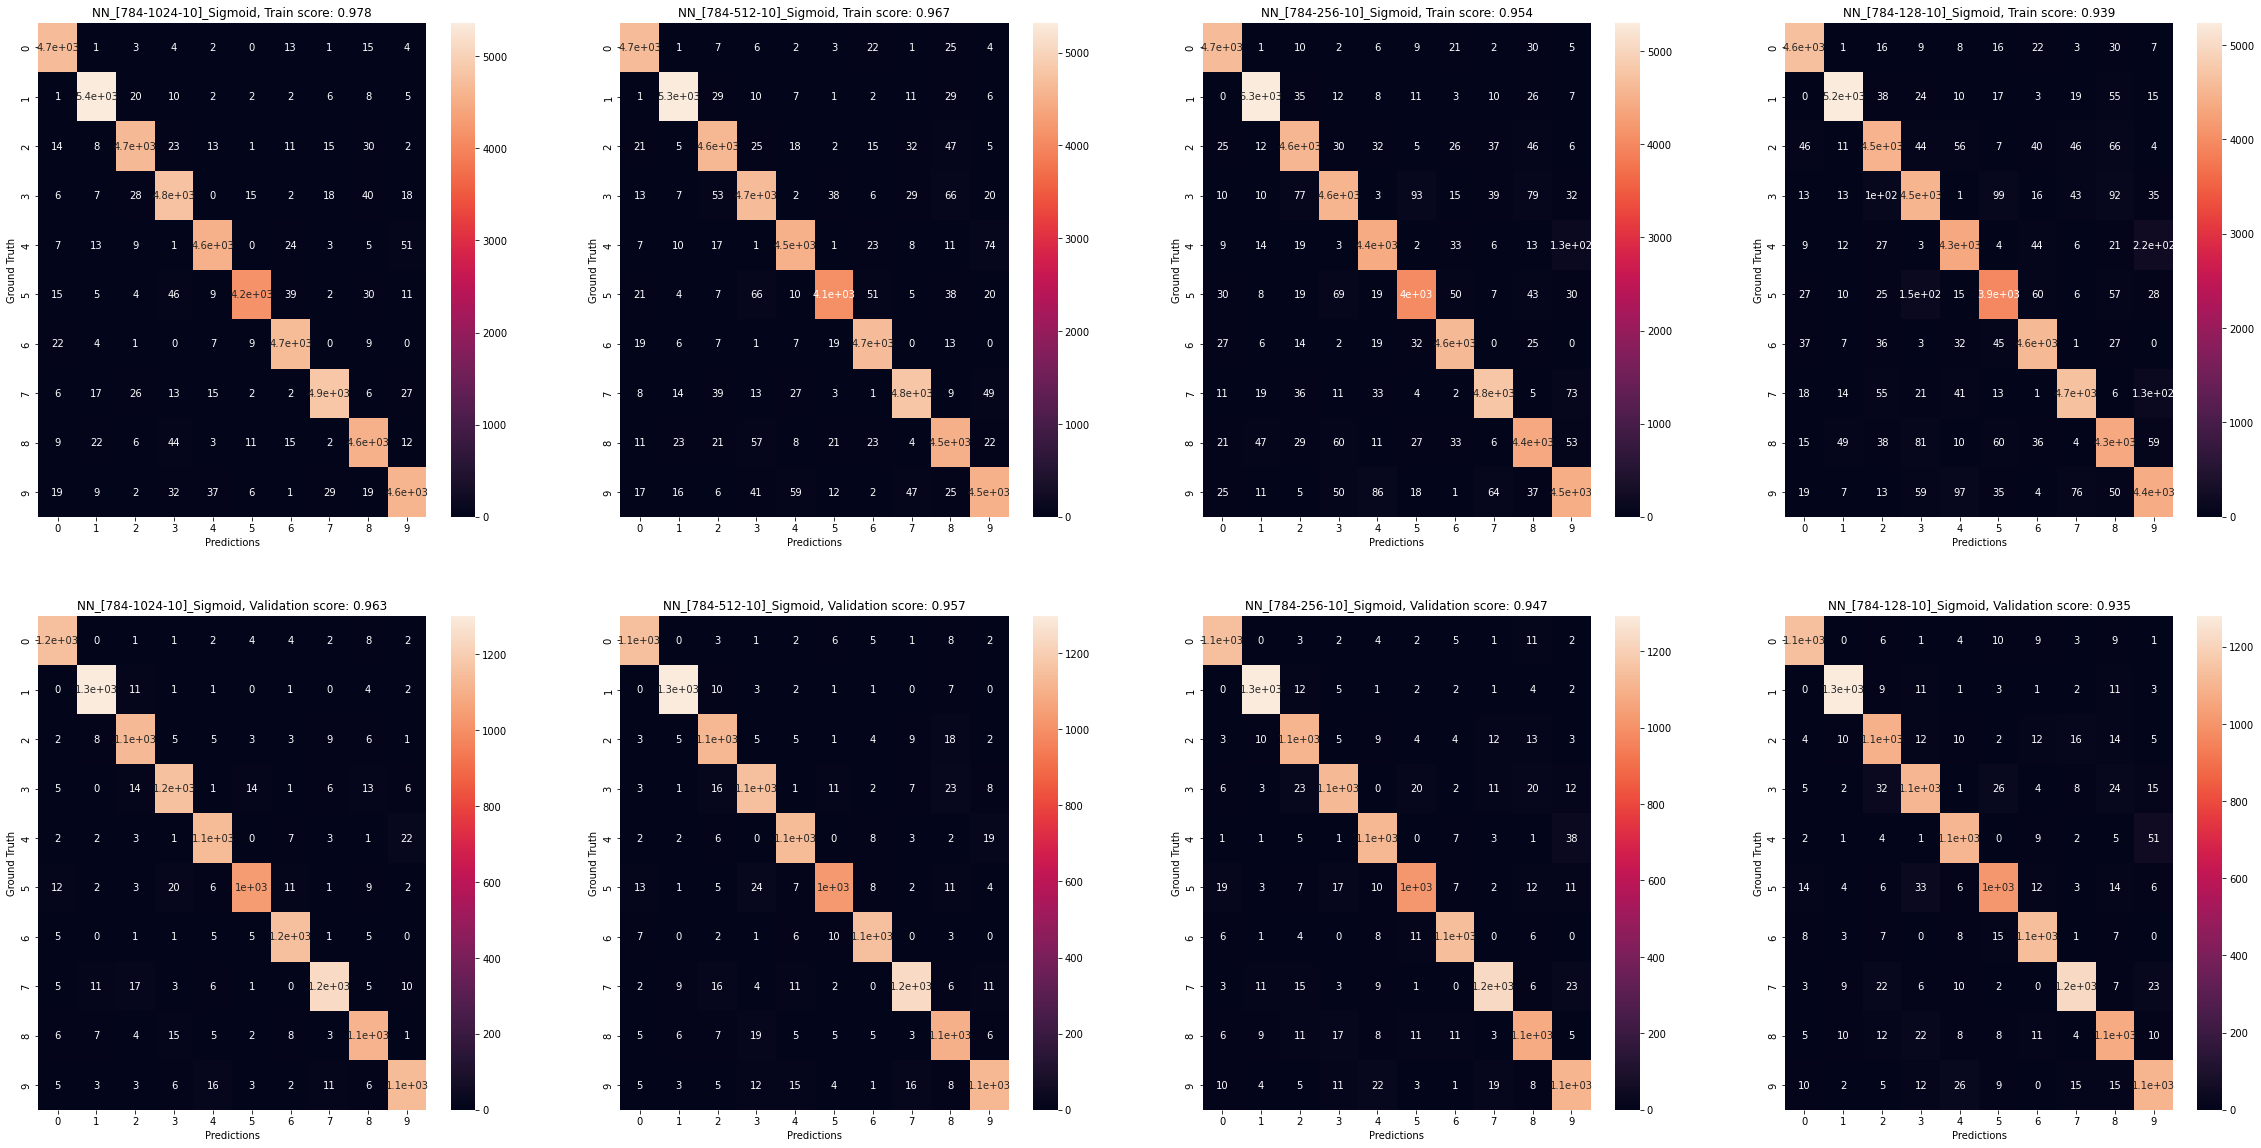

In [36]:
experiment_1 = [
    {
        "hidden_sizes": [1024],
        "weight_init_fn": xavier_normal_init, 
        "activation_type": Sigmoid,
        "lr": 3e-4,
        "max_iter": 10
    },
    {
        "hidden_sizes": [512],
        "weight_init_fn": xavier_normal_init, 
        "activation_type": Sigmoid,
        "lr": 3e-4,
        "max_iter": 10
    },
    {
        "hidden_sizes": [256],
        "weight_init_fn": xavier_normal_init, 
        "activation_type": Sigmoid,
        "lr": 3e-4,
        "max_iter": 10
    },
    {
        "hidden_sizes": [128],
        "weight_init_fn": xavier_normal_init, 
        "activation_type": Sigmoid,
        "lr": 3e-4,
        "max_iter": 10
    },
]

run_experiment(experiment=experiment_1, data_size=X_train.shape[0])

### 3.2 Network Depth

NN_[784-1024-512-10]_Sigmoid
Train Loss (0.124), Validation Loss (0.149): 100% 10/10 [00:02:32]
NN_[784-1024-512-256-10]_Sigmoid
Train Loss (0.165), Validation Loss (0.182): 100% 10/10 [00:02:55]
NN_[784-1024-512-256-128-10]_Sigmoid
Train Loss (0.264), Validation Loss (0.265): 100% 10/10 [00:03:04]
NN_[784-1024-512-256-128-64-10]_Sigmoid
Train Loss (1.076), Validation Loss (0.998): 100% 10/10 [00:02:54]


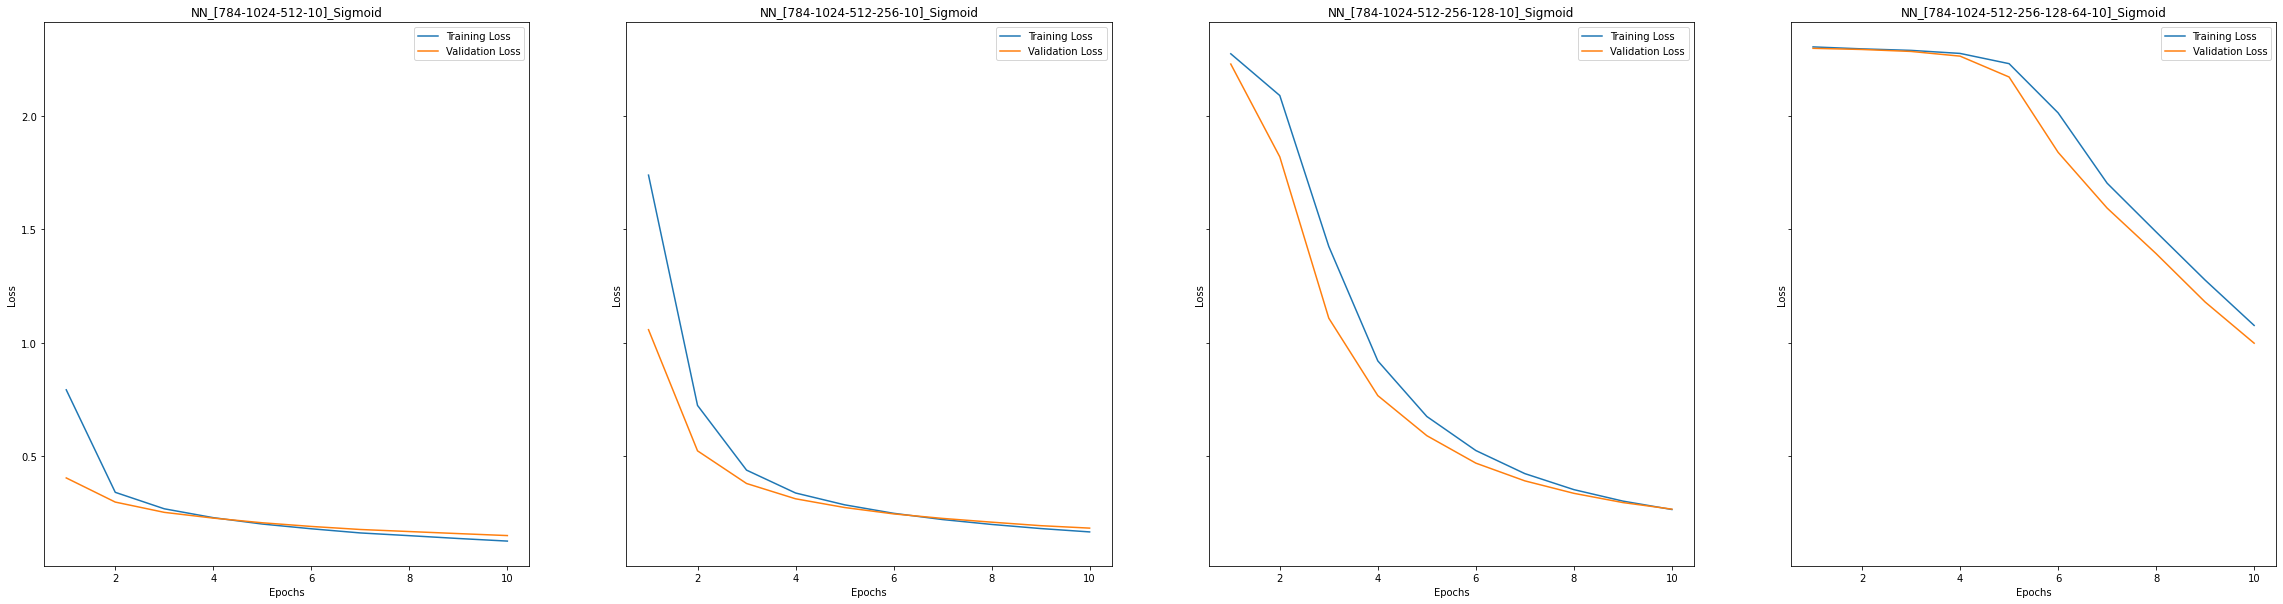

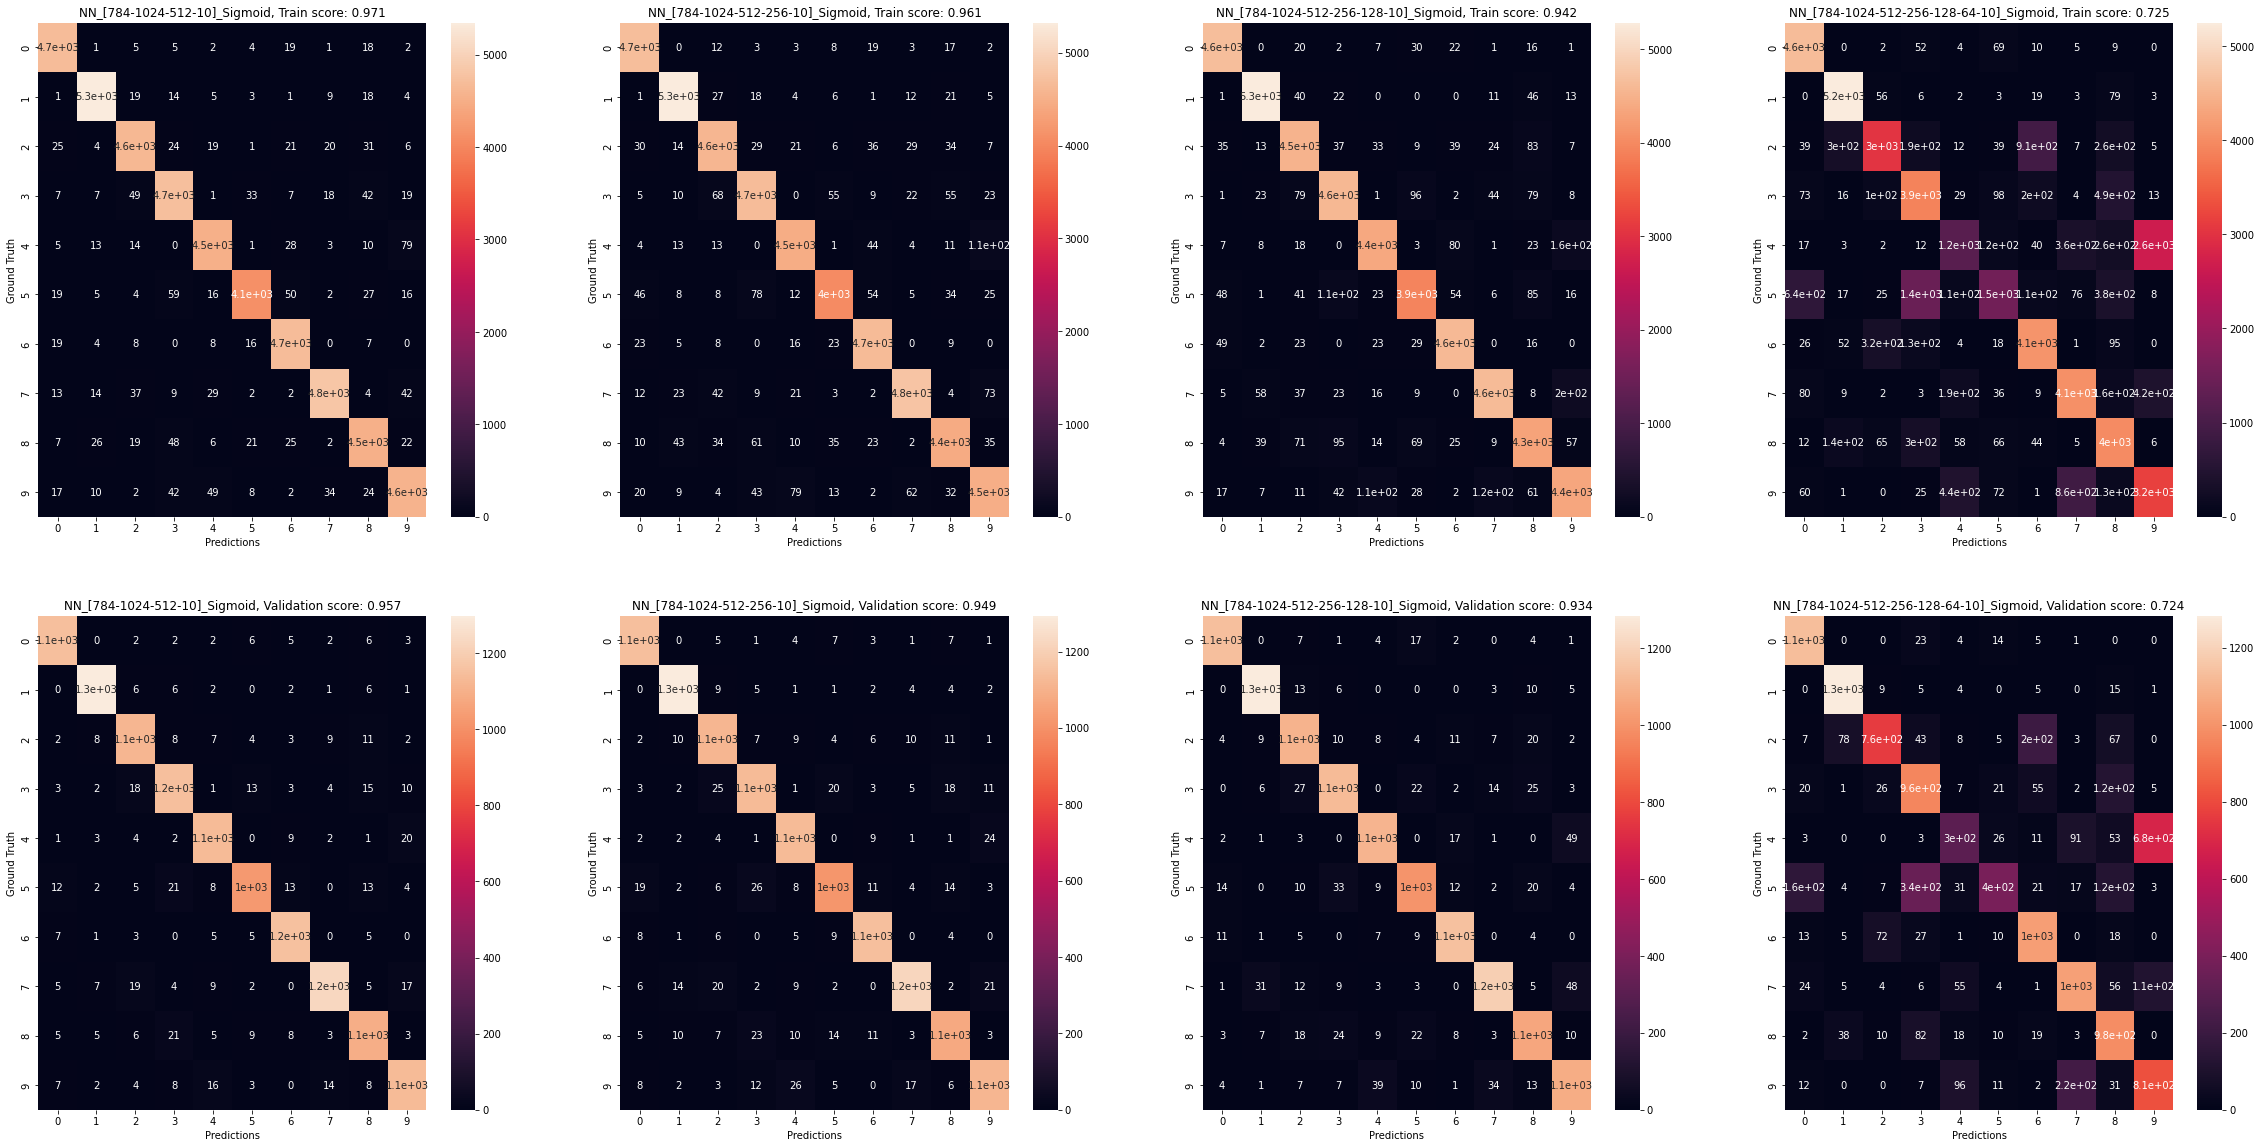

In [37]:
experiment_2 = [
    {
        "hidden_sizes": [1024, 512],
        "weight_init_fn": xavier_normal_init, 
        "activation_type": Sigmoid,
        "lr": 3e-4,
        "max_iter": 10
    },
    {
        "hidden_sizes": [1024, 512, 256],
        "weight_init_fn": xavier_normal_init, 
        "activation_type": Sigmoid,
        "lr": 3e-4,
        "max_iter": 10
    },
    {
        "hidden_sizes": [1024, 512, 256, 128],
        "weight_init_fn": xavier_normal_init, 
        "activation_type": Sigmoid,
        "lr": 3e-4,
        "max_iter": 10
    },
    {
        "hidden_sizes": [1024, 512, 256, 128, 64],
        "weight_init_fn": xavier_normal_init, 
        "activation_type": Sigmoid,
        "lr": 3e-4,
        "max_iter": 10
    }
]

run_experiment(experiment=experiment_2, data_size=X_train.shape[0])

### 3.3 More iterations

NN_[784-1024-512-256-128-64-10]_Sigmoid
Train Loss (0.226), Validation Loss (0.261): 100% 30/30 [00:09:09]
NN_[784-1024-512-256-128-128-10]_Sigmoid
Train Loss (0.250), Validation Loss (0.257): 100% 30/30 [00:09:19]
NN_[784-1024-512-256-256-128-10]_Sigmoid
Train Loss (0.279), Validation Loss (0.290): 100% 30/30 [00:10:24]
NN_[784-1024-512-512-256-128-10]_Sigmoid
Train Loss (0.269), Validation Loss (0.261): 100% 30/30 [00:10:52]
NN_[784-1024-1024-512-256-128-10]_Sigmoid
Train Loss (0.242), Validation Loss (0.265): 100% 30/30 [00:15:35]


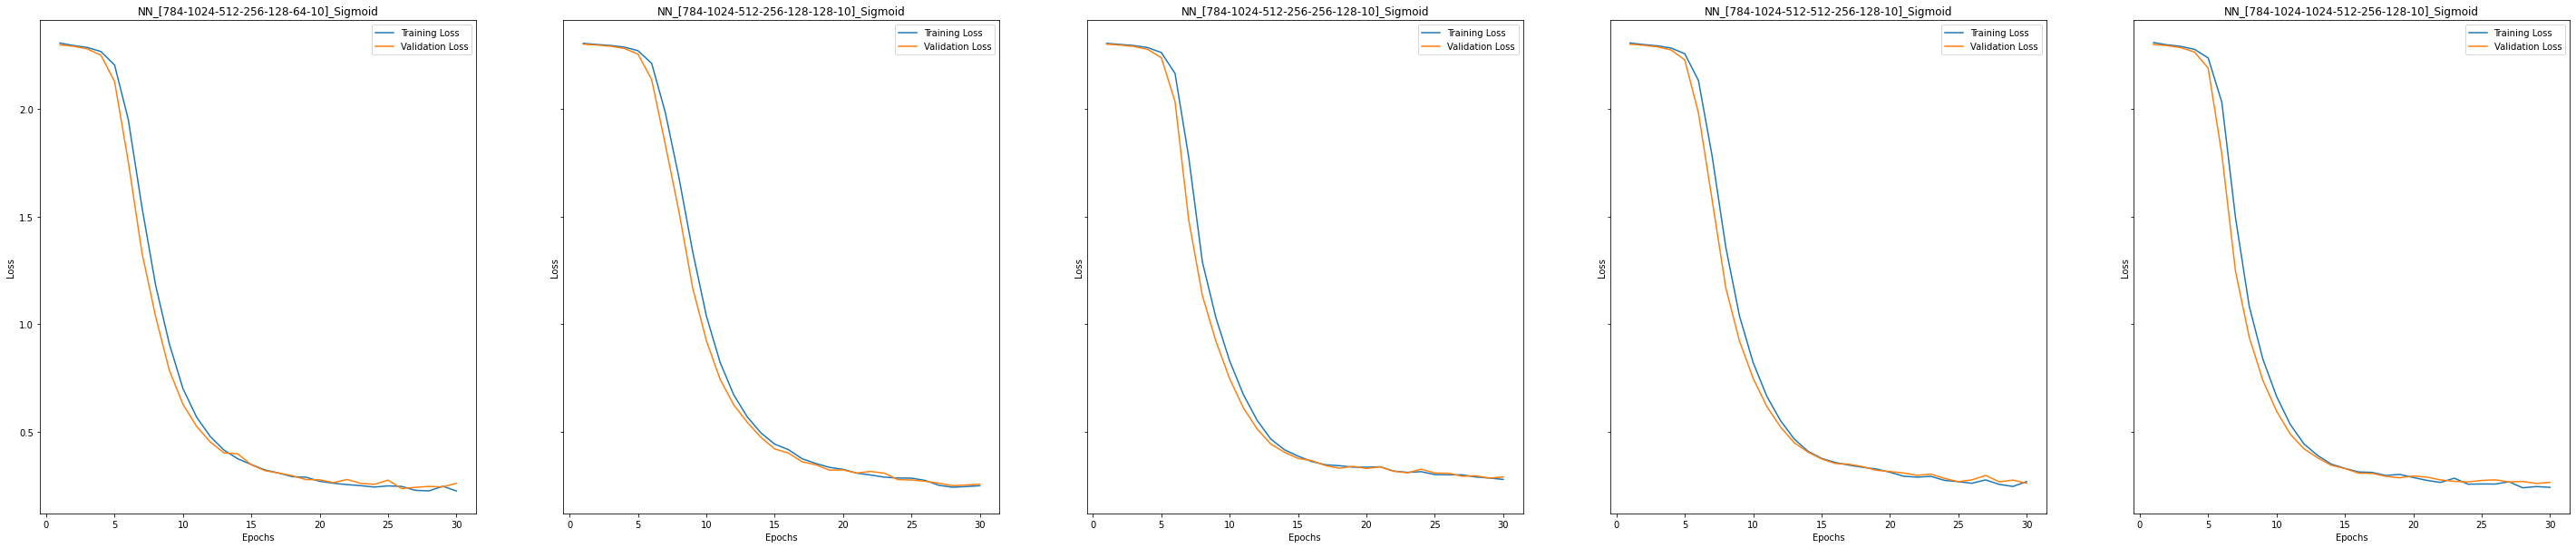

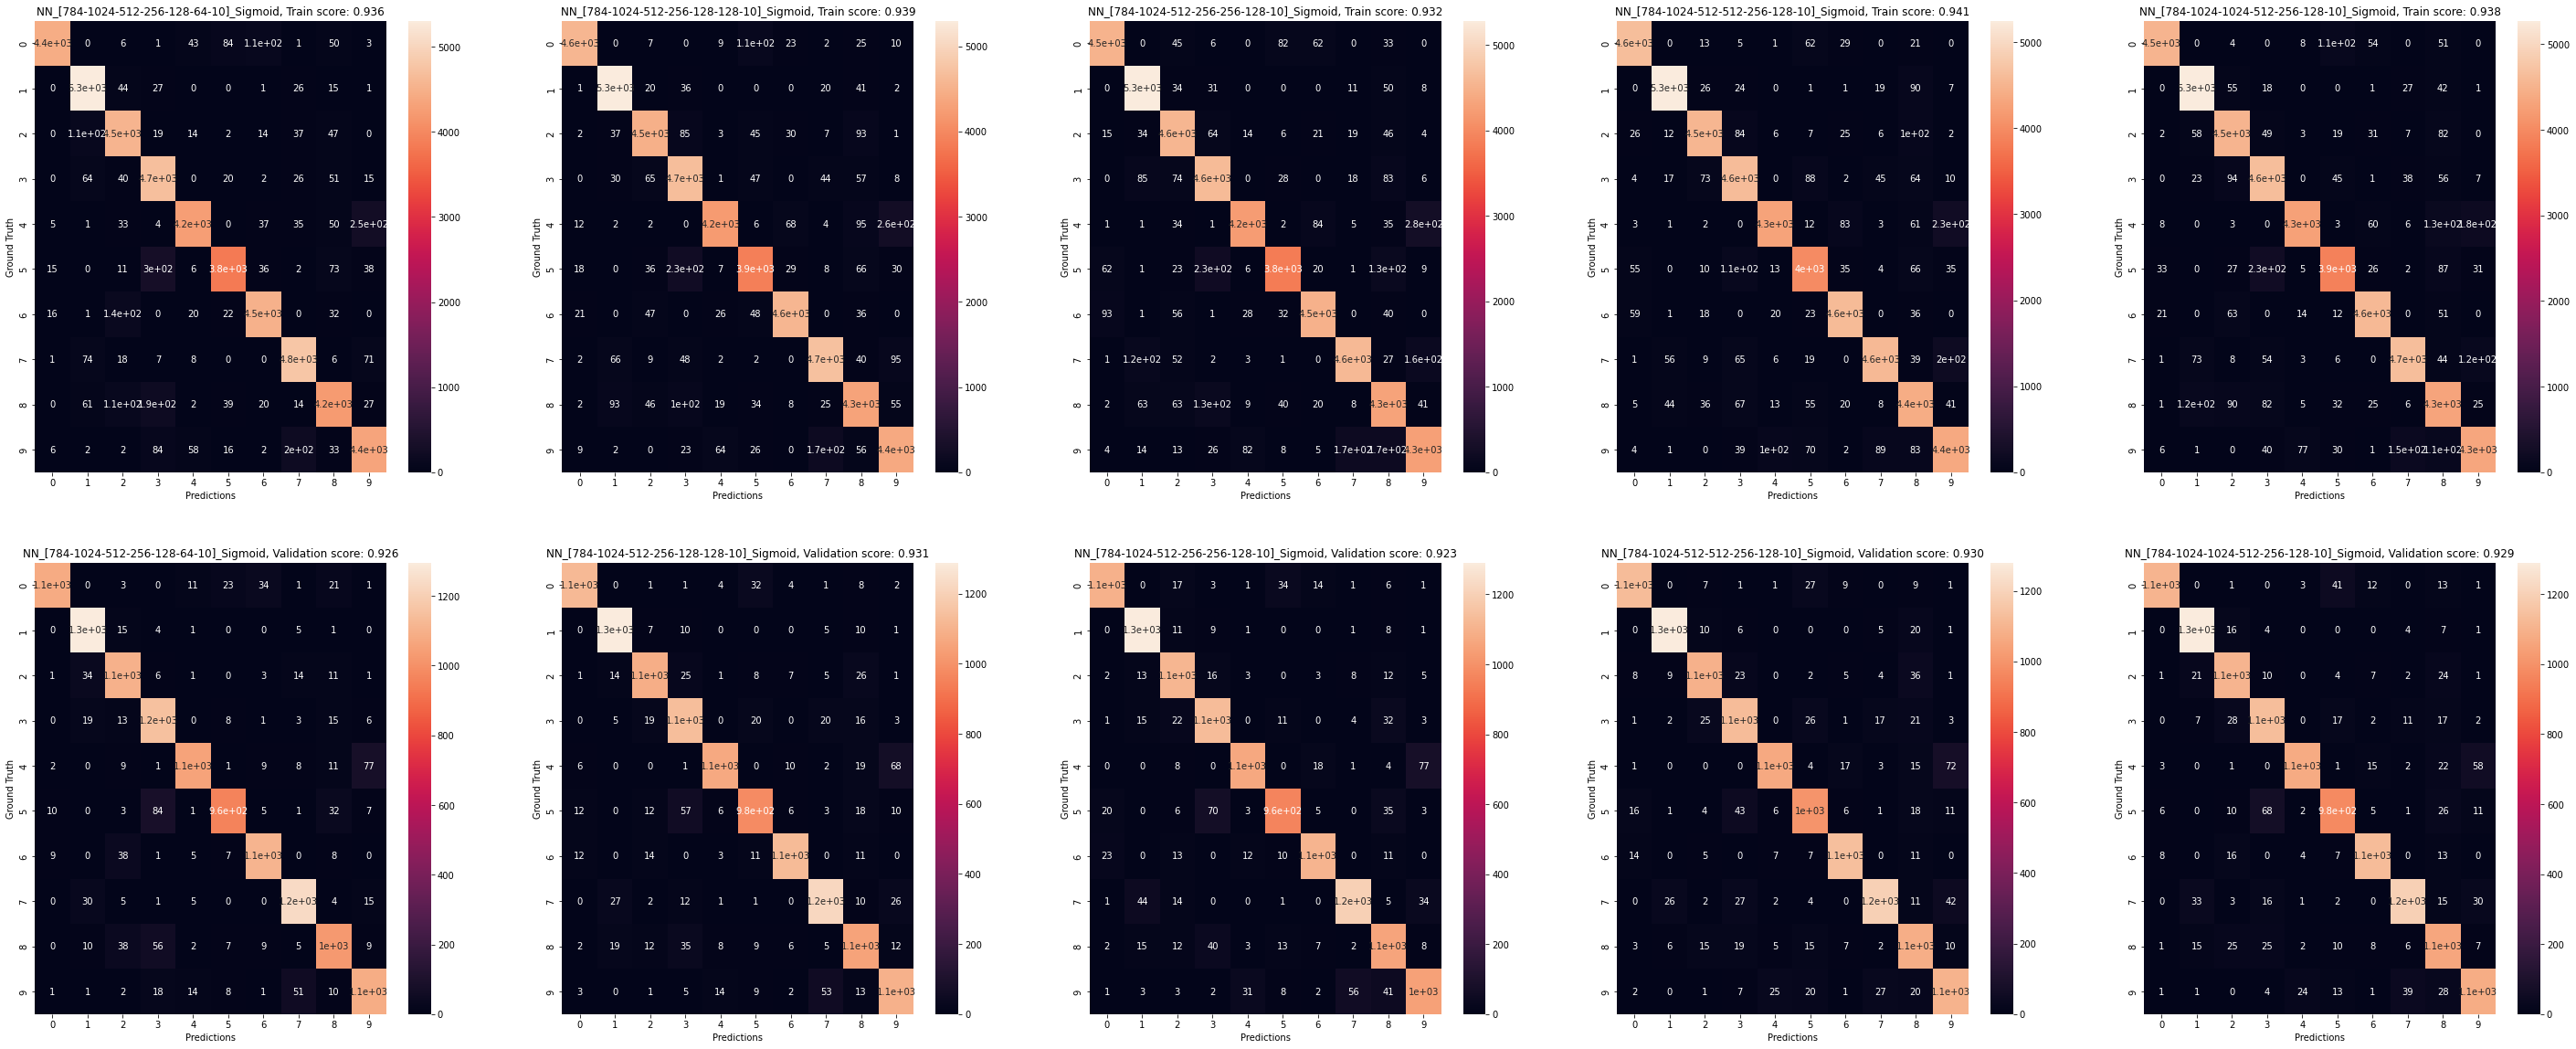

In [39]:
experiment_3 = [
    {
        "hidden_sizes": [1024, 512, 256, 128, 64],
        "weight_init_fn": xavier_normal_init, 
        "activation_type": Sigmoid,
        "lr": 3e-4,
        "max_iter": 30
    },
    {
        "hidden_sizes": [1024, 512, 256, 128, 128],
        "weight_init_fn": xavier_normal_init, 
        "activation_type": Sigmoid,
        "lr": 3e-4,
        "max_iter": 30
    },
    {
        "hidden_sizes": [1024, 512, 256, 256, 128],
        "weight_init_fn": xavier_normal_init, 
        "activation_type": Sigmoid,
        "lr": 3e-4,
        "max_iter": 30
    },
    {
        "hidden_sizes": [1024, 512, 512, 256, 128],
        "weight_init_fn": xavier_normal_init, 
        "activation_type": Sigmoid,
        "lr": 3e-4,
        "max_iter": 30
    },
    {
        "hidden_sizes": [1024, 1024, 512, 256, 128],
        "weight_init_fn": xavier_normal_init, 
        "activation_type": Sigmoid,
        "lr": 3e-4,
        "max_iter": 30
    },
]

run_experiment(experiment=experiment_3, data_size=X_train.shape[0])

### 3.4 Learning Rate Scheduling

In [ ]:
# TODO